Primero, voy a exportar el dataframe y limpiarlo de valores repetidos o nulos.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

from google.colab import drive

drive.mount('/content/drive')

ruta_archivo = '/content/drive/MyDrive/vgchartz-2024.csv'
df = pd.read_csv(ruta_archivo, encoding='latin-1')
#print(df)

df.dropna(inplace=True)
df_sin_dups = df.drop_duplicates()
print('Esta es la información del dataset ya sin duplicados y valores nulos como NaN')
print(df_sin_dups)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Esta es la información del dataset ya sin duplicados y valores nulos como NaN
                                                 img  \
1      /games/boxart/full_5563178AmericaFrontccc.jpg   
4      /games/boxart/full_4990510AmericaFrontccc.jpg   
7      /games/boxart/full_4653215AmericaFrontccc.jpg   
8      /games/boxart/full_1977964AmericaFrontccc.jpg   
9      /games/boxart/full_4649679AmericaFrontccc.png   
...                                              ...   
11794  /games/boxart/full_2874583AmericaFrontccc.jpg   
11920  /games/boxart/full_4489495AmericaFrontccc.jpg   
12216  /games/boxart/full_5524695AmericaFrontccc.jpg   
13198  /games/boxart/full_5198003AmericaFrontccc.jpg   
15044      /games/boxart/full_8777680PALFrontccc.png   

                              title console             genre  \
1                Grand Theft Auto V     PS4            

Ahora, hay que entender la información que se está trabajando

In [3]:
df_sin_dups.info()
df_sin_dups.head()

<class 'pandas.core.frame.DataFrame'>
Index: 282 entries, 1 to 15044
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   img           282 non-null    object 
 1   title         282 non-null    object 
 2   console       282 non-null    object 
 3   genre         282 non-null    object 
 4   publisher     282 non-null    object 
 5   developer     282 non-null    object 
 6   critic_score  282 non-null    float64
 7   total_sales   282 non-null    float64
 8   na_sales      282 non-null    float64
 9   jp_sales      282 non-null    float64
 10  pal_sales     282 non-null    float64
 11  other_sales   282 non-null    float64
 12  release_date  282 non-null    object 
 13  last_update   282 non-null    object 
dtypes: float64(6), object(8)
memory usage: 33.0+ KB


,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03
4,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14
7,/games/boxart/full_4653215AmericaFrontccc.jpg,Red Dead Redemption 2,PS4,Action-Adventure,Rockstar Games,Rockstar Games,9.8,13.94,5.26,0.21,6.21,2.26,2018-10-26,2018-11-02
8,/games/boxart/full_1977964AmericaFrontccc.jpg,Call of Duty: Black Ops II,X360,Shooter,Activision,Treyarch,8.4,13.86,8.27,0.07,4.32,1.20,2012-11-13,2018-04-07
9,/games/boxart/full_4649679AmericaFrontccc.png,Call of Duty: Black Ops II,PS3,Shooter,Activision,Treyarch,8.0,13.80,4.99,0.65,5.88,2.28,2012-11-13,2018-04-07


Ahora, por cada columna vemos:
0. Img contiene una imagen del videojuego
1. El titulo del juego
2. Es la consola para la que se vendió el juego
3. Es el género del videojuego
4. Es la empreza que publica el juego
5. Es el estudio desarrollador del videojuego
6. Es el puntaje de la crítica (en escala de 10)
7. Son las ventas totales
8. Son ventas en norteamérica
9. Son las ventas en japón
10. Son las ventas en regiones PAL
11. Son ventas en otras regiones
12. Es la fecha de lanzamiento
13. Es la fecha de la última actualización

Las ventas están en miles de copias.

También, hay que entender qué es lo que queremos hacer para aplicar el Random Forest necesario. Ya que queremos categorizar los vídeojuegos por popularidad, lo que necesitamos es un bosque de clasificación.
A continuación crearé las clasificaciones de popularidad basándome en la puntuación de la crítica.

In [4]:
# Crear categorías de popularidad basadas en total_sales
df_sin_dups['Popularidad'] = pd.qcut(df_sin_dups['critic_score'],
                                      q=3,
                                      labels=['Menos populares', 'Moderadamente populares', 'Muy populares'])

print(df_sin_dups[['title', 'critic_score', 'Popularidad']].head())

                        title  critic_score              Popularidad
1          Grand Theft Auto V           9.7            Muy populares
4   Call of Duty: Black Ops 3           8.1  Moderadamente populares
7       Red Dead Redemption 2           9.8            Muy populares
8  Call of Duty: Black Ops II           8.4            Muy populares
9  Call of Duty: Black Ops II           8.0  Moderadamente populares


Y ahora voy a dividir en conjuntos de entrenamiento y prueba

In [5]:
# Seleccionar las características relevantes
X = df_sin_dups[['total_sales', 'critic_score']]  # Variables predictoras
y = df_sin_dups['Popularidad']                   # Variable objetivo (Popularidad)
# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Y ahora sí, a entrenar el modelo :D

In [6]:
# Crear el modelo Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
modelo_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Vamos a evaluar el modelito

In [7]:
# Hacer predicciones en los datos de prueba
y_pred = modelo_rf.predict(X_test)

# Evaluar el modelo
print("Exactitud del modelo:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

Exactitud del modelo: 1.0

Reporte de clasificación:
                          precision    recall  f1-score   support

        Menos populares       1.00      1.00      1.00        19
Moderadamente populares       1.00      1.00      1.00        21
          Muy populares       1.00      1.00      1.00        17

               accuracy                           1.00        57
              macro avg       1.00      1.00      1.00        57
           weighted avg       1.00      1.00      1.00        57



¿Cuál es la importancia de las características?

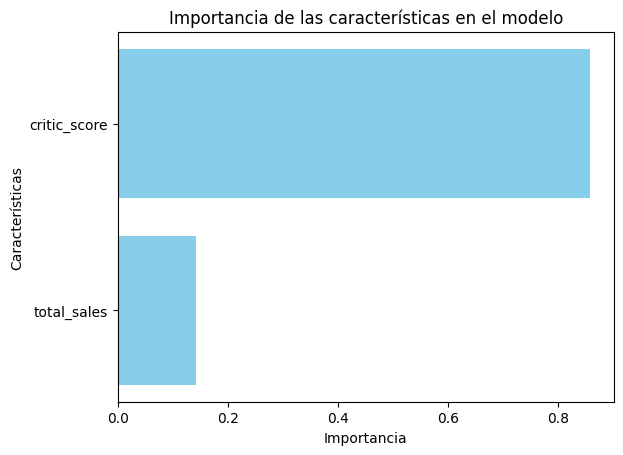

In [8]:
# Importancia de las características
importancias = modelo_rf.feature_importances_
caracteristicas = X.columns

# Gráfico de barras
plt.barh(caracteristicas, importancias, color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las características en el modelo')
plt.show()

Según las características que seleccioné, la puntuación de la critica es más importante que las ventas totales

Vamos a realizar más gráficos con predicciones y matriz de confusión

<Figure size 800x600 with 0 Axes>

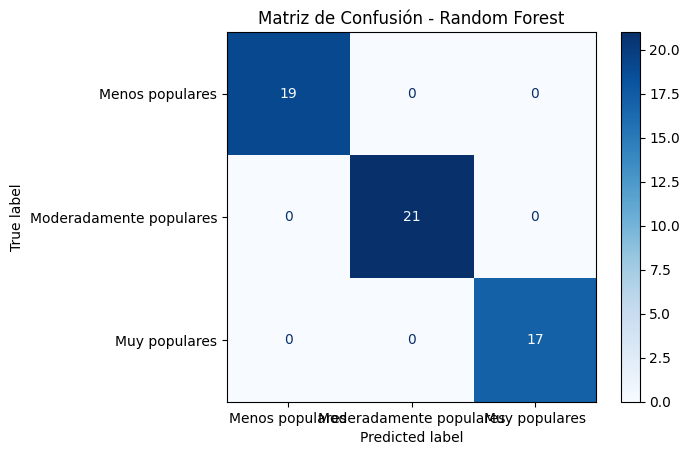

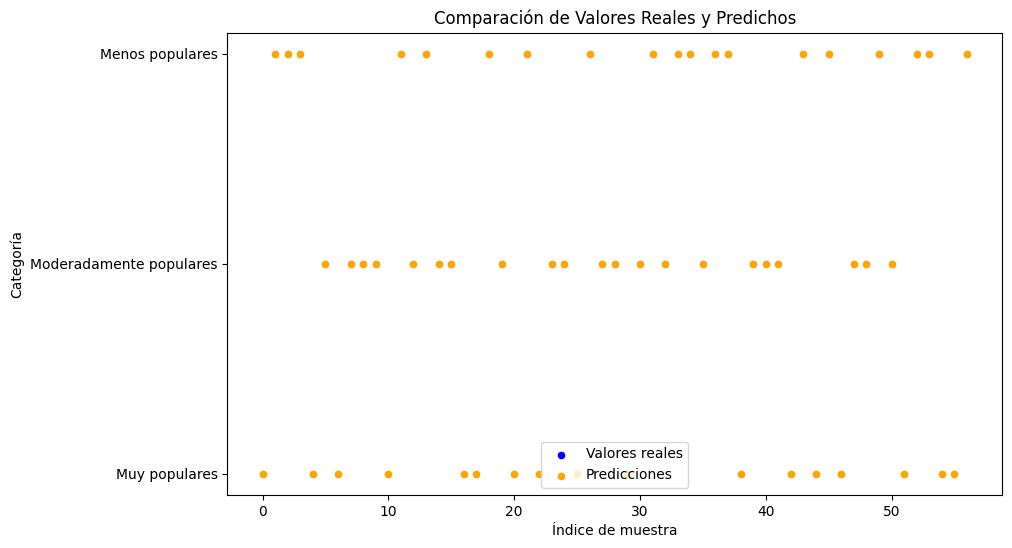

In [13]:
# Realizar predicciones en el conjunto de prueba
y_pred = modelo_rf.predict(X_test)

# 1. Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred, labels=modelo_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=modelo_rf.classes_)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title('Matriz de Confusión - Random Forest')
plt.show()

# 2. Comparación entre valores reales y predichos
plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(y_test)), y=y_test, label='Valores reales', color='blue')
sns.scatterplot(x=range(len(y_pred)), y=y_pred, label='Predicciones', color='orange')
plt.title('Comparación de Valores Reales y Predichos')
plt.xlabel('Índice de muestra')
plt.ylabel('Categoría')
plt.legend()
plt.show()

La primera gráfica nos dice que todos los valores predichos son verdaderos, pues todos los datos se encuentran en la diagonal principal. De la misma forma, en la segunda gráfica los valores de las predicciones están encima de los valores reales, es por esto que no se ven, por lo que el modelo clasifica correctamente los juegos por popularidad de la forma que se definió ésta.